In [1]:
# Import necessary libraries
import os
import cv2
import easyocr
import xml.etree.ElementTree as ET
import pytesseract
import numpy as np
from sklearn.model_selection import train_test_split
from utils import get_labels, load_dataset, preprocess_data
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model # type: ignore
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Input, AveragePooling2D # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from keras_cv.losses import IoULoss # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # type: ignore

/Users/urlu/Developer/repos/Registration-Plate-Recognition/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load and preprocess data
xml_path = './archive/annotations/'
img_path = './archive/images/'
dataset = {}
history = None

# Loop over all the xml files and get the data
for xml_file in os.listdir(xml_path):
    x = os.path.join(xml_path, xml_file)
    extracted = get_labels(x)
    filename = extracted['filename']
    dataset[filename] = extracted

# Get all the data from images and xml files
images, boxes = load_dataset(img_path, xml_path)

# Preprocess the images and boxes (resize images and adjust boxes with scale)
imgs_preprocessed, boxes_preprocessed = preprocess_data(images, boxes)

# Splitting the data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(imgs_preprocessed, boxes_preprocessed, test_size=0.15)

In [3]:
# Define model building, saving, and loading functions
def build_custom_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(3,3),

        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        AveragePooling2D(16),

        Flatten(),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        # Dropout(0.5),
        Dense(4, activation='sigmoid')
    ])
    optimizer = Adam(learning_rate=0.01)  # Adjusted learning rate
    model.compile(optimizer='adam', loss='mean_squared_error')
    # model.compile(optimizer=optimizer, loss=IoULoss(bounding_box_format='xyxy', mode='linear'))
    return model

def save_model(model, path):
    model.save(path)

def load_custom_model(path):
    return load_model(path)

model_path = 'models/model.keras'

In [4]:
# Train the model
# Check if the model already exists
if os.path.exists(model_path):
    model = load_custom_model(model_path)
else:
    model = build_custom_model(input_shape=(500,500,3))

    # Got idea for callbacks from chatgpt
    callbacks = [
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-5),
        EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    ]

    history = model.fit(X_train, y_train, epochs=1, validation_data=(X_test, y_test), batch_size=4, callbacks=callbacks)

    # Save the model after training
    save_model(model, model_path)

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 294ms/step


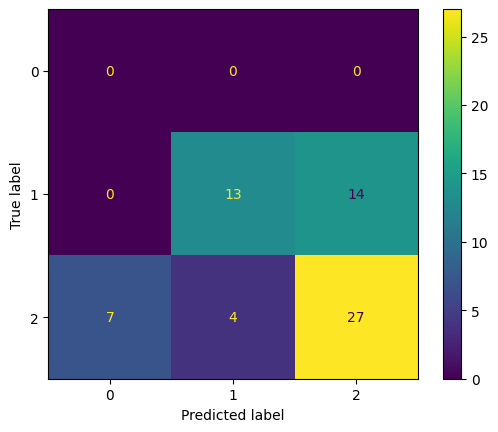

In [5]:
# Confusion matrix
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

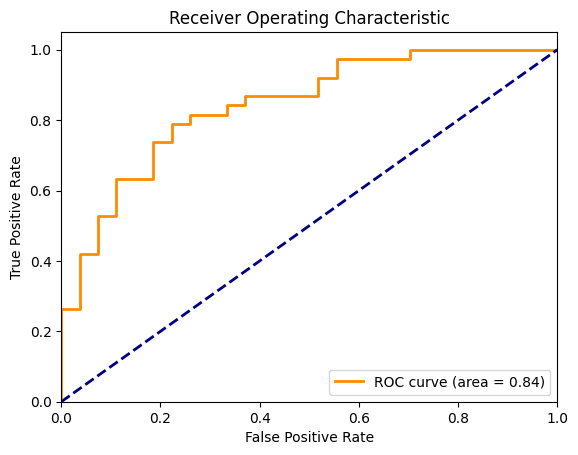

In [6]:
# Roc curve and AUC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1], pos_label=3)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

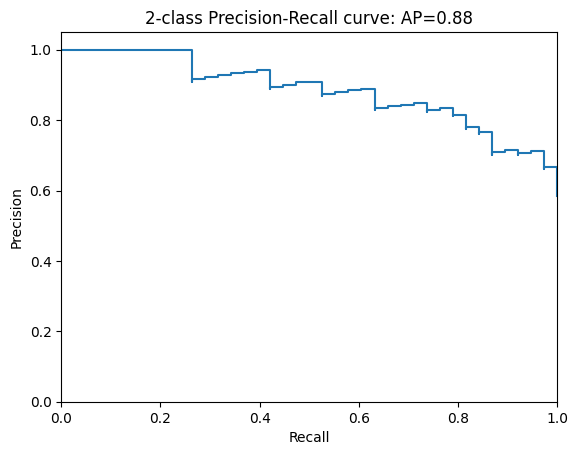

In [7]:
# Precision-recall curve
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_true, y_pred[:, 1], pos_label=3)
average_precision = average_precision_score(y_true, y_pred[:, 1], pos_label=3)

plt.figure()
plt.step(recall, precision, where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.show()

In [8]:
reader = easyocr.Reader(['en'])

def load_and_predict(image_path):
    image = cv2.imread(image_path)
    og_image = image.copy()

    image = cv2.resize(image, (500, 500))
    image = image / 255.0
    image = np.expand_dims(image, axis=0)

    predicted = model.predict(image)[0]

    original_h, original_w = og_image.shape[:2]

    xmin, ymin, xmax, ymax = predicted
    xmin, xmax = int(xmin * original_w), int(xmax * original_w)
    ymin, ymax = int(ymin * original_h), int(ymax * original_h)

    # Draws a rectangle over the detected registration plate
    cv2.rectangle(og_image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)

    # Get some margin, transform it to gray and read the text
    img2 = og_image[ymin-10:ymax+10, xmin-10:xmax+10]
    grey_img = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Use EasyOCR to detect text
    result = reader.readtext(grey_img)
    text = ' '.join([res[1] for res in result])
    print(f"Plate detected: {text}")

    # Display the text top right of the rectangle
    cv2.putText(og_image, text, (xmin-5, ymin-5), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)

    cv2.imshow("Detected plate " + text, og_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


/Users/urlu/Developer/repos/Registration-Plate-Recognition/.venv/lib/python3.12/site-packages/easyocr/detection.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load

In [9]:
# Example:
load_and_predict('./img/testImg.jpg')
load_and_predict('./img/testImg2.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Plate detected: CCC444


2024-08-08 09:22:44.742 Python[11386:83776] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Plate detected: KY7O CHT


|              | correct value | predicted value |
|--------------|---------------|-----------------|
| Prediction 1 | S CCC 444     | CCC444          |
| Prediction 2 | KY70 CWT      | KY70 CHT        |

![Prediction](img/prediction.jpg)

![Prediction 2](img/prediction2.jpg)
